In [1]:
# imports and wandb login
import wandb, os, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import numpy as np

sns.set_style("ticks")
os.environ["WANDB_NOTEBOOK_NAME"] = "xslorenz_mroberta_results.py"
wandb.login()

wandb: Currently logged in as: golkar. Use `wandb login --relogin` to force relogin


True

## Showing the scaling vs. width

The best runs were selected as part of WandB hyperparameter search

In [2]:
# Downloading the wandb search results and putting them in a dataframe
api = wandb.Api()
runs = api.runs("xslorenz_mroberta")

results = []

num_params = {
    120: 2484742,
    240: 9145342,
    360: 19981942,
    480: 34994542,
    720: 77547742,
    1440: 305431342,
}

for run in runs:
    if run.state not in ["finished", "running"]:
        continue

    run_dict = {
        "hidden_size": run.config["hidden_size"],
        "id": run.id,
        "config": run.config,
        "summary": run.summary,
        "eval/loss": run.summary["eval/loss"],
        "num_params": num_params[run.config["hidden_size"]] // 100000 / 10,
    }

    results.append(run_dict)


df = pd.DataFrame(results)

# select the top two eval/loss for each hidden size of the dataframe
df_bests = df.groupby("hidden_size", as_index=False).apply(
    lambda x: x.nsmallest(2, "eval/loss")
)

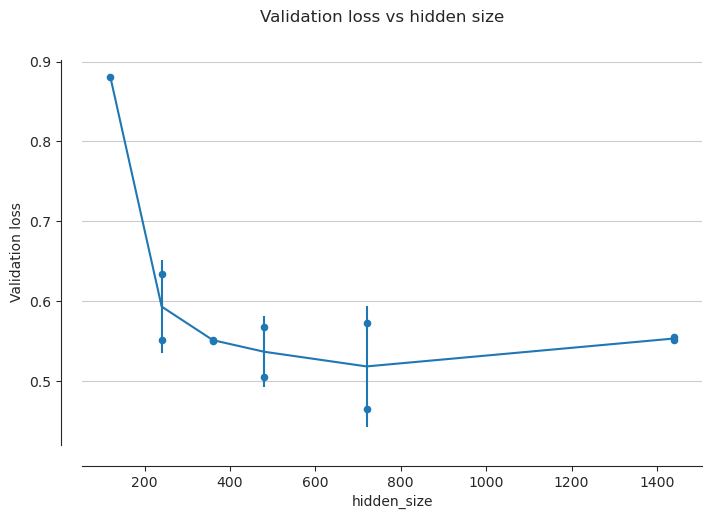

In [6]:
# Performance vs embedding width (the variance shows the top 2 runs)

df_mean_n_std = df_bests.groupby("hidden_size", as_index=False)["eval/loss"].aggregate(
    ["mean", "std"]
)
ax = df_bests.plot.scatter(x="hidden_size", y="eval/loss", figsize=(8, 5))
df_mean_n_std.plot(y="mean", yerr="std", kind="line", ax=ax)


ax.set_title("")
plt.suptitle("Validation loss vs hidden size")
ax.set_ylabel("Validation loss")

# turn the legend off
ax.legend().set_visible(False)

ax.grid(axis="y")
sns.despine(offset=15)


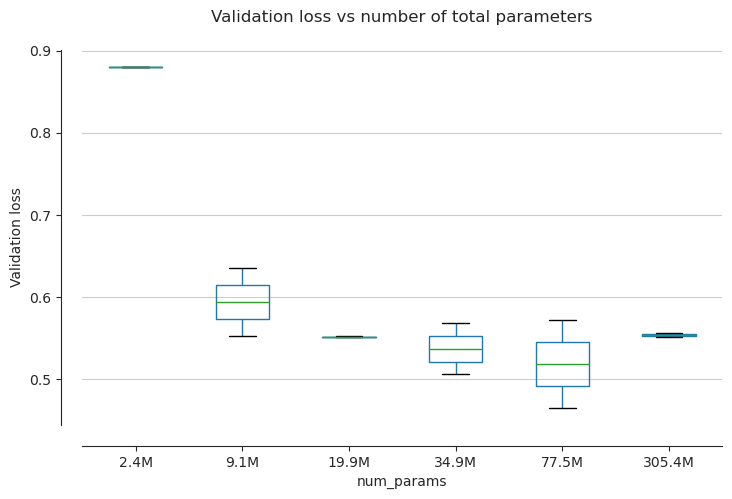

In [5]:
# Performance vs number of parameters (the variance shows the top two runs for each hidden size)

ax = df_bests.boxplot(
    by="num_params",
    column=["eval/loss"],
    showfliers=True,
    showmeans=False,
    figsize=(8, 5),
)
ax.set_title("")
plt.suptitle("Validation loss vs number of total parameters")
ax.set_ylabel("Validation loss")

ax.set_xticklabels([item.get_text() + "M" for item in ax.get_xticklabels()])

ax.grid(axis="x")
sns.despine(offset=15)

## Exploring the performance of the best trained model

In [8]:
# Loading the best trained model and the dataset

from transformers import RobertaForMaskedLM, PreTrainedTokenizerFast, pipeline
from datasets import DatasetDict

best_run_path = "/mnt/home/sgolkar/ceph/saves/xslorenz/mroberta/wandb/run-20230529_104249-rw7ta38d/files/model/checkpoint-200000"

model = RobertaForMaskedLM.from_pretrained(best_run_path).cuda()


wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer_lorenz.json",
    bos_token="[END]",
    eos_token="[END]",
    mask_token="?",
    pad_token="[PAD]",
)

# defining the mask filling pipeline
mask_filler = pipeline("fill-mask", model=model, tokenizer=wrapped_tokenizer, device=0)

### We look at the performance of the model at predicting the first Lorenz parameter.

In [9]:
# Loading the raw dataset and masking the first Lorenz parameter
path = "/mnt/home/sgolkar/ceph/datasets/microcosm/lorenz_world_xsmall/clean/"
ds = DatasetDict.from_text(
    {"train": path + "train_set", "test": path + "test_set", "val": path + "val_set"}
)

def remove_params(sample):
    text = sample["text"].replace(" ", "")
    split1 = text.partition("params':[")
    split2 = [split1[0], "params':[?.", split1[2].partition(".")[2]]
    ans = int(split1[2].partition(".")[0])
    masked_text = "".join(split2)
    return {"masked_text": masked_text, "answer": ans}


ds_with_ans = ds.map(remove_params, batched=False, num_proc=30)

Found cached dataset text (/home/sgolkar/.cache/huggingface/datasets/text/default-718ba8aa9074c963/0.0.0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/sgolkar/.cache/huggingface/datasets/text/default-718ba8aa9074c963/0.0.0/cache-c386d1133cb9a33d_*_of_00030.arrow
Loading cached processed dataset at /home/sgolkar/.cache/huggingface/datasets/text/default-718ba8aa9074c963/0.0.0/cache-d43c42c2dd43b79d_*_of_00030.arrow
Loading cached processed dataset at /home/sgolkar/.cache/huggingface/datasets/text/default-718ba8aa9074c963/0.0.0/cache-022fa920f8a14575_*_of_00030.arrow


#### An example of the mask-filling problem

In [42]:
# suppress python warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sample = ds_with_ans["val"][2]
preds = mask_filler(sample["masked_text"])

# splitting the text to make it more readable
print('sample masked text (broken to two lines for readability):\n')
print(sample["masked_text"].split(",'data'")[0])
print(''.join(sample["masked_text"].partition(",'data'")[1:]),'\n')

print("correct answer:", sample["answer"], '\n')
print('model predictions:')
for pred in preds:
    print(' - {}, score: {:.1%}'.format(pred["token_str"],pred["score"]))

# length of the tokenized sample
print('\nlength of the tokenized sample:',len(wrapped_tokenizer(sample["masked_text"])["input_ids"]))

sample masked text (broken to two lines for readability):

{'description':{'num_sys':2,'sys0':{'params':[?.152,3.537,24.64],'init_point':[-4.305,5.582,2.844],'step_size':700,'name':'lorenz','step_multip':16},'sys1':{'params':[9.65,2.656,49.1],'init_point':[2.82,-2.244,1.573],'step_size':700,'name':'lorenz','step_multip':2},'normalization':[[-6.273,-5.418,14.63,2.508,3.695,1.577],[4.73,9.445,12.69,0.576,3.518,0.2213]],'embedding':[[[-0.007442,0.03894,0.0629,0.1823],[-0.3167,0.164,0.3513,-0.8022],[-0.1804,-0.5703,-0.3389,-0.401],[0.668,0.166,-0.5664,-0.374],[-0.1547,0.784,-0.1506,-0.0649],[-0.6304,0.064,-0.6436,0.1354]],[1.0,1.0,100.0,100.0],[[-0.387,-0.3381,-0.8276,-0.2251],[0.619,0.519,-0.379,-0.451],[-0.646,0.763,-0.009384,-0.001003],[0.2217,0.1837,-0.4136,0.864]]]}
,'data':[[-59.28,43.16,23.22,-50.2],[-62.75,60.4,10.92,-24.83],[-66.44,75.06,1.29,-4.977],[-69.94,87.5,-6.434,10.94],[-73.1,98.06,-12.78,24.02],[-75.7,106.94,-18.19,35.16],[-77.3,114.0,-22.9,44.9],[-78.0,119.44,-27.2,53.78

#### How well does it perform quantitatively?

We look at two performance measures:
* (root) mean square error of the prediction
* top 1,3,5 classification accuracy

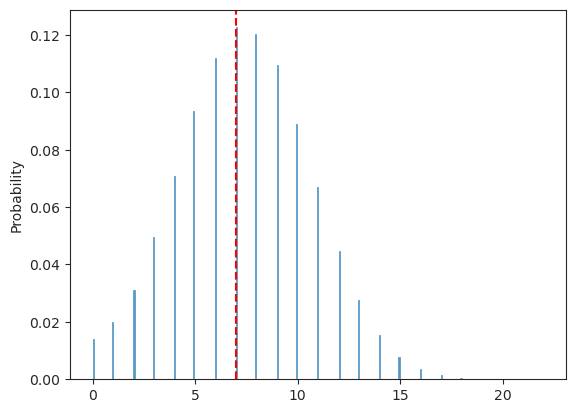

In [44]:
# Looking at the distribution of the answers in the train and test sets to set up a baseline

ans_dist_train = np.array(ds_with_ans["train"]["answer"])
ans_mean_train = int(np.mean(ans_dist_train))
sns.histplot(ans_dist_train, stat="probability")
plt.axvline(ans_mean_train, color="red", linestyle="--")
plt.show()

# sorting the digits by their frequency in the train set
top_digits = np.argsort([(ans_dist_train == el).mean() for el in range(23)])[::-1]

Computing the output of the model over the test set. The results are saved to preds_anss_probs.npz.

In [58]:
# preds = []
# anss = []
# probs = []
# for sample in tqdm(ds_with_ans["test"]):
#     out = mask_filler(sample["masked_text"])

#     pred = []
#     score = []
#     miss_count = 0
#     for el in out:
#         # continue if the token is not a number
#         if el["token_str"].isnumeric():
#             pred.append(int(el["token_str"]))
#             score.append(el["score"])
#         else:
#             miss_count += 1

#     prob = np.zeros(100)
#     prob[pred] = score

#     ans = sample["answer"]

#     preds.append(pred+[99]*miss_count)
#     anss.append(ans)
#     probs.append(prob)

# preds = np.array(preds)
# anss = np.array(anss)
# probs = np.array(probs)

# # save preds, anss, probs to numpy file
# np.savez(
#     "./preds_anss_probs.npz",
#     preds=preds,
#     anss=anss,
#     probs=probs,
# )

# load preds, anss, probs from numpy file
preds_anss_probs = np.load("./preds_anss_probs.npz")

anss = preds_anss_probs["anss"]
preds = preds_anss_probs["preds"]
probs = preds_anss_probs["probs"]



RMSE performance comparison:

The learned model is usually within ±1 of the real answer.

In [48]:
print("baseline RMSE: {:.2f}".format(anss.std()))
print("learned RMSE: {:.2f}".format(np.sqrt(np.mean((anss - preds[:, 0]) ** 2))))

baseline RMSE: 3.21
learned RMSE: 1.10


Top accuracy performance comparison:

In [13]:
# comparing baseline and learned top 1 accuracy
print("baseline top 1 accuracy: {:.1%}".format((anss == ans_mean_train).mean()))
print("learned top 1 accuracy: {:.1%}".format((anss == preds[:, 0]).mean()))

baseline top 1 accuracy: 12.1%
learned top 1 accuracy: 56.3%


In [49]:
# comparing baseline and learned top 2 accuracy
baseline_top2 = [ans in top_digits[:2] for ans in anss]
print("baseline top 2 accuracy: {:.1%}".format(np.mean(baseline_top2)))
learned_top2 = [ans in pred[:2] for ans, pred in zip(anss, preds)]
print("learned top 2 accuracy: {:.1%}".format(np.mean(learned_top2)))

baseline top 2 accuracy: 24.0%
learned top 2 accuracy: 80.4%


In [50]:
# comparing baseline and learned top 3 accuracy
baseline_top3 = [ans in top_digits[:3] for ans in anss]
print("baseline top 3 accuracy: {:.1%}".format(np.mean(baseline_top3)))
learned_top3 = [ans in pred[:3] for ans, pred in zip(anss, preds)]
print("learned top 3 accuracy: {:.1%}".format(np.mean(learned_top3)))

baseline top 3 accuracy: 35.3%
learned top 3 accuracy: 90.2%


In [51]:
# comparing baseline and learned top 5 accuracy
baseline_top5 = [ans in top_digits[:5] for ans in anss]
print("baseline top 5 accuracy: {:.1%}".format(np.mean(baseline_top5)))
learned_top5 = [ans in pred[:5] for ans, pred in zip(anss, preds)]
print("learned top 5 accuracy: {:.1%}".format(np.mean(learned_top5)))

baseline top 5 accuracy: 55.5%
learned top 5 accuracy: 96.9%


Text(0.5, 0, 'true answer - predicted answer')

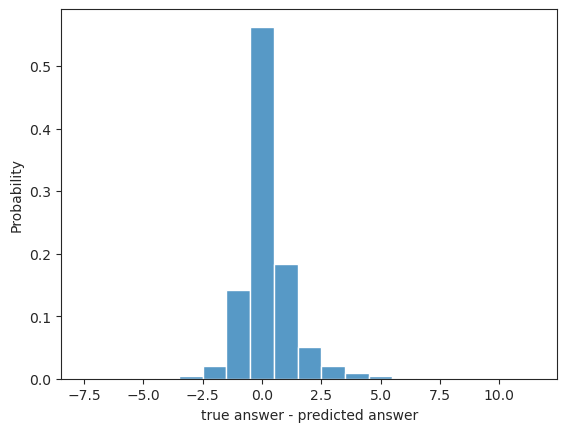

In [107]:
# sns histogram of the difference between true answer and the predicted answer
# set sns histogram bar width to 1
sns.histplot(anss - preds[:, 0], stat="probability", discrete=True)
plt.xlabel("true answer - predicted answer")



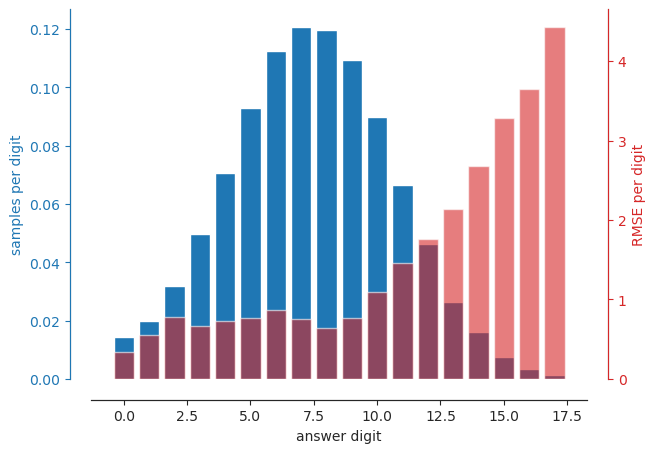

In [111]:
plt.bar(range(18), [(anss == digit).sum()/len(anss) for digit in range(18)])
plt.xlabel("answer digit")
plt.ylabel("samples per digit", color="tab:blue")
# change the color of the left axis to tab:blue
plt.gca().tick_params(axis='y', colors='tab:blue')

ax2 = plt.twinx()
ax2.bar(range(18), [np.sqrt(((digit - preds[anss == digit,0])**2).mean()) for digit in range(18)], alpha=0.6, color="tab:red")
ax2.set_ylabel("RMSE per digit", color="tab:red")
ax2.tick_params(axis='y', colors='tab:red')
ax2.spines["right"].set_color("tab:red")

plt.gca().spines["left"].set_color("tab:blue")

# sns despine the top axis only
sns.despine(offset=15, top=True, right=False, left=False, bottom=False)